In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# RandomForest (train raw)

In [ ]:
# Cargar datos de entrenamiento
df_train = pd.read_csv("../data/train_reviews.csv")
df_train['text'] = df_train['text'].fillna("")
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['year'] = df_train['date'].dt.year

# Seleccionar características adicionales de review, por ejemplo:
other_features = ['useful', 'funny', 'cool', 'year']
X_other_train = df_train[other_features].values

# Procesar el texto con TF-IDF en el training
tfidf = TfidfVectorizer(max_features=5000)
X_text_train_tfidf = tfidf.fit_transform(df_train['text'])

# Reducir la dimensionalidad del texto
svd = TruncatedSVD(n_components=50, random_state=42)
X_text_train_svd = svd.fit_transform(X_text_train_tfidf)

In [ ]:
X_text_train_svd.shape, X_other_train.shape

In [3]:
# Combinar las características numéricas con el embedding del texto
X_train = np.hstack([X_other_train, X_text_train_svd])
y_train = df_train['stars']

# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Entrenar el modelo RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42, verbose=1, n_jobs=-1)
model.fit(X_train_final, y_train_final)

# Predecir en el conjunto de validación para evaluar
y_pred_val = model.predict(X_val)
print("MAE en validación:", mean_absolute_error(y_val, y_pred_val))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 18.7min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


MAE en validación: 0.720318928216396


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.4s finished


In [5]:
# Ahora, procesar el conjunto de test (sin ajustar de nuevo el vectorizador ni el SVD)
df_test = pd.read_csv('../data/test_reviews.csv')
df_test['text'] = df_test['text'].fillna("")
df_test['date'] = pd.to_datetime(df_test['date'])
df_test['year'] = df_test['date'].dt.year

X_other_test = df_test[other_features].values

# Transformar el texto de test con el vectorizador y el SVD ya ajustados
X_text_test_tfidf = tfidf.transform(df_test['text'])
X_text_test_svd = svd.transform(X_text_test_tfidf)

# Combinar las características
X_test = np.hstack([X_other_test, X_text_test_svd])

# Realizar las predicciones en el conjunto de test
predictions = model.predict(X_test)

# Crear el DataFrame con el formato requerido: review_id, stars
df_output = pd.DataFrame({
    'review_id': df_test['review_id'],
    'stars': predictions.round(0)  
})

# Exportar el CSV con las predicciones
df_output.to_csv('random_forest_review_predictions.csv', index=False)
print("Predicciones exportadas a 'test_review_predictions.csv'")

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.8s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.0s finished


Predicciones exportadas a 'test_review_predictions.csv'


# RandomForest (train + neg)

In [3]:
df_train = pd.read_csv("../data/train_reviews_merged_neg.csv")
df_train['text'] = df_train['text'].fillna("")

df_train.sample(5)

,stars,useful,funny,cool,text,date,stars_neg,review_count_neg,is_open_neg,categories_neg,state_AZ_neg,state_FL_neg,state_IN_neg,state_LA_neg,state_MO_neg,state_NJ_neg,state_Others_neg,state_PA_neg,state_TN_neg
215273,1.0,-0.391093,-0.150312,-0.251644,I just lost my appetite since i found a hair i...,2022,1.5,-0.066319,True,Restaurante,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
517673,5.0,0.266410,0.300774,0.762869,"Architecture, architecture, architecture. Yes,...",2011,4.5,5.723902,True,Restaurante,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
777874,4.0,-0.391093,-0.150312,-0.251644,I just stopped by here today on my lunch break...,2018,2.5,-0.129687,True,Belleza,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
158084,2.0,-0.391093,-0.150312,-0.251644,"Had lunch there last week. November 18th, 2011...",2011,3.0,-0.288106,False,Restaurante,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
872204,5.0,-0.391093,-0.150312,-0.251644,"Love mobile crust, they get busy so make a res...",2021,4.0,3.632769,True,Restaurante,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Omito state_* ya que no son muy representativas para el modelo

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_numeric = df_train[["useful", "funny", "cool", "stars_neg", "review_count_neg", "categories_neg"]].copy()
X_numeric["is_open_neg"] = df_train["is_open_neg"].astype(int)

X_numeric

,useful,funny,cool,stars_neg,review_count_neg,categories_neg,is_open_neg
0,-0.391093,-0.150312,-0.251644,4.5,0.773303,Restaurante,1
1,0.266410,-0.150312,0.255613,2.5,-0.177212,Otros,1
2,-0.391093,-0.150312,-0.251644,2.5,-0.296027,Compras,1
3,-0.391093,-0.150312,-0.251644,4.5,0.226757,Restaurante,0
4,2.896420,1.654029,3.299152,4.0,-0.105924,Restaurante,1
...,...,...,...,...,...,...,...
967779,-0.062341,-0.150312,-0.251644,4.5,0.812908,Restaurante,0
967780,-0.391093,-0.150312,-0.251644,4.5,0.900038,Restaurante,1
967781,-0.391093,-0.150312,0.255613,4.5,1.961447,Restaurante,1
967782,-0.391093,-0.150312,-0.251644,4.5,21.478689,Restaurante,1


In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
X_numeric['categories_neg'] = label_encoder.fit_transform(X_numeric['categories_neg'])

X_numeric.sample(5)

,useful,funny,cool,stars_neg,review_count_neg,categories_neg,is_open_neg
39325,-0.391093,0.300774,-0.251644,2.5,1.509952,3,1
604082,-0.391093,-0.150312,-0.251644,4.0,10.571529,4,1
327693,-0.391093,-0.150312,-0.251644,4.5,-0.256422,5,0
551199,-0.391093,-0.150312,-0.251644,4.0,24.892622,4,1
62225,1.252664,0.751859,1.777382,4.0,0.923801,4,1


In [11]:
tfidf = TfidfVectorizer(stop_words='english', max_features=15000, ngram_range=(1, 2))
X_text = tfidf.fit_transform(df_train["text"])

svd = TruncatedSVD(n_components=50, random_state=42)
X_text_reduced = svd.fit_transform(X_text)

In [12]:
X_text_reduced.shape, X_numeric.shape, X_text.shape

((967784, 50), (967784, 7), (967784, 15000))

In [13]:
X_final = np.hstack([X_numeric.values, X_text_reduced])

y = df_train["stars"]

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((774227, 57), (193557, 57), (774227,), (193557,))

In [ ]:
model = RandomForestRegressor(n_estimators=50, random_state=42, verbose=1, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.9min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.3s


MAE: 0.6504618713276782


[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.6s finished


In [15]:
from sklearn.ensemble import HistGradientBoostingRegressor

model = HistGradientBoostingRegressor(random_state=42, learning_rate=0.01, verbose=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

Binning 0.318 GB of training data: 0.454 s
Binning 0.035 GB of validation data: 0.028 s
Fitting gradient boosted rounds:
Fit 100 trees in 7.462 s, (3100 total leaves)
Time spent computing histograms: 4.971s
Time spent finding best splits:  0.217s
Time spent applying splits:      0.515s
Time spent predicting:           0.156s
MAE: 0.9138355907740634


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=42, learning_rate=0.01, verbose=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

In [19]:
from sklearn.ensemble import AdaBoostRegressor

model = AdaBoostRegressor(random_state=42, learning_rate=0.001, n_estimators=6, 
                          estimator=RandomForestRegressor(n_estimators=50, random_state=42, verbose=1, n_jobs=-1))

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.9min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.7min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    1.3s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.0

KeyboardInterrupt: 

In [20]:
import xgboost as xgb
xgb.set_config(verbosity=2)

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

reg = XGBRegressor(
    tree_method="hist",
    eval_metric=mean_absolute_error,
)

reg.fit(X_train, y_train, verbose=1)
y_pred = reg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

[22:17:25] INFO: C:\actions-runner\_work\xgboost\xgboost\src\data\iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (774227, 57, 44130939).
MAE: 0.6327845813593447


In [ ]:
from sklearn.ensemble import VotingRegressor

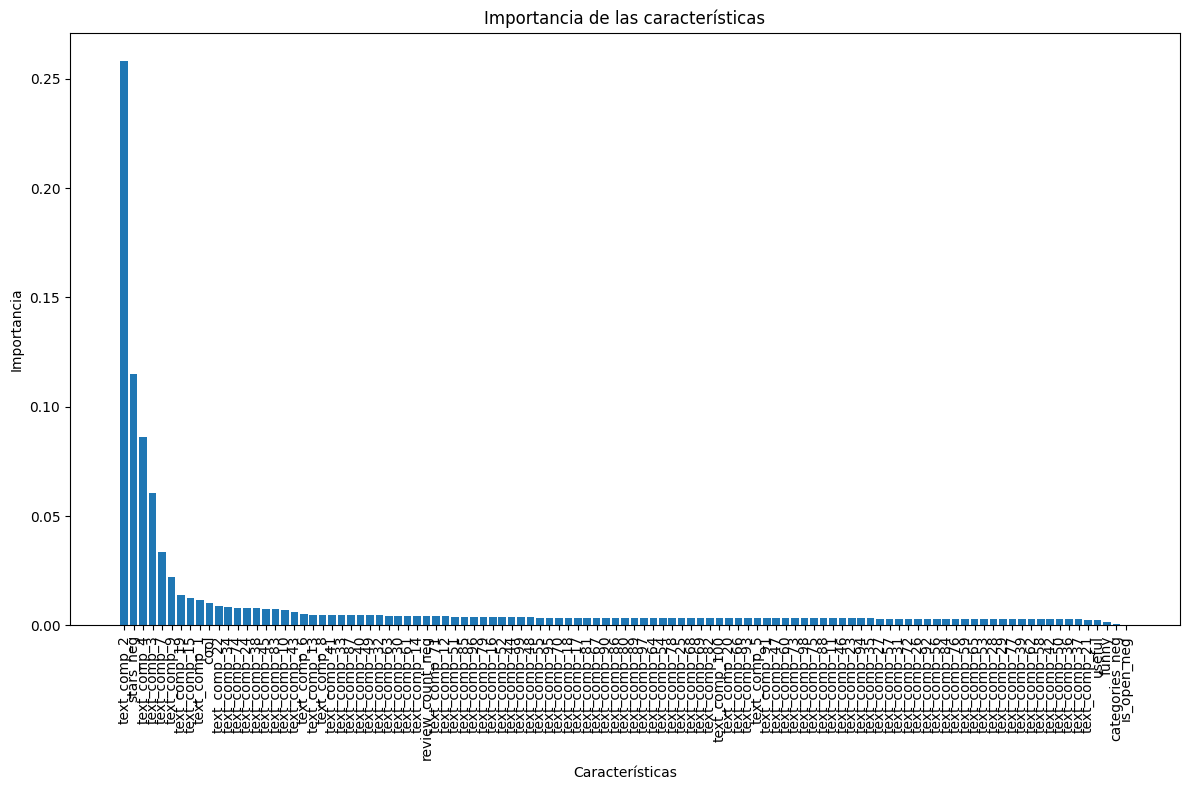

In [34]:
importances = model.feature_importances_

numeric_feature_names = list(X_numeric.columns)
text_feature_names = [f"text_comp_{i+1}" for i in range(X_text_reduced.shape[1])]
feature_names = numeric_feature_names + text_feature_names

indices = np.argsort(importances)[::-1]

# Crear la gráfica
plt.figure(figsize=(12, 8))
plt.title("Importancia de las características")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.tight_layout()
plt.show()

In [21]:
# Ahora, procesar el conjunto de test (sin ajustar de nuevo el vectorizador ni el SVD)
df_test = pd.read_csv('../data/test_reviews_merged_neg.csv')
df_test['text'] = df_test['text'].fillna("")

Y_numeric = df_test[["useful", "funny", "cool", "stars_neg", "review_count_neg", "categories_neg"]].copy()
Y_numeric["is_open_neg"] = df_test["is_open_neg"].astype(int)

Y_numeric

,useful,funny,cool,stars_neg,review_count_neg,categories_neg,is_open_neg
0,-0.063127,-0.164229,0.253789,4.5,1.375296,Restaurante,1
1,0.917552,-0.164229,0.759641,4.0,0.583200,Restaurante,1
2,0.263766,-0.164229,-0.252063,3.5,0.765382,Otros,1
3,0.263766,-0.164229,-0.252063,4.0,1.256481,Restaurante,1
4,-0.390020,-0.164229,-0.252063,2.5,3.561480,Hotelería,1
...,...,...,...,...,...,...,...
414760,-0.390020,-0.164229,-0.252063,4.0,15.997386,Restaurante,1
414761,-0.390020,-0.164229,-0.252063,4.0,-0.288106,Restaurante,1
414762,-0.390020,-0.164229,-0.252063,3.5,2.777305,Restaurante,0
414763,0.917552,-0.164229,0.253789,4.5,1.304007,Restaurante,0


In [22]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y_numeric['categories_neg'] = label_encoder.fit_transform(Y_numeric['categories_neg'])

Y_numeric.sample(5)

,useful,funny,cool,stars_neg,review_count_neg,categories_neg,is_open_neg
248840,-0.390020,-0.164229,-0.252063,4.0,-0.272264,5,1
152912,0.917552,0.323761,0.759641,4.0,-0.224738,3,1
189329,-0.063127,-0.164229,-0.252063,4.0,2.206996,4,1
29260,-0.390020,-0.164229,-0.252063,4.0,5.216961,4,1
386890,-0.063127,-0.164229,0.253789,4.0,1.684213,4,1


In [23]:
Y_text_test_tfidf = tfidf.transform(df_test['text'])
Y_text_test_svd = svd.transform(Y_text_test_tfidf)

X_test = np.hstack([Y_numeric, Y_text_test_svd])

predictions = reg.predict(X_test)

In [24]:
# Crear el DataFrame con el formato requerido: review_id, stars
df_output = pd.DataFrame({
    'review_id': df_test['review_id'],
    'stars': predictions.round(0)
})

# Exportar el CSV con las predicciones
df_output.to_csv('xgboost_review_predictions_neg_0.csv', index=False)
print("Predicciones exportadas a 'xgboost_review_predictions_neg_0.csv'")

Predicciones exportadas a 'xgboost_review_predictions_neg_0.csv'


# RandomForest (train + neg + DL)

In [3]:
df_train = pd.read_csv("../data/train_reviews_merged_neg.csv")
df_train['text'] = df_train['text'].fillna("")

df_train.sample(5)

,stars,useful,funny,cool,text,date,stars_neg,review_count_neg,is_open_neg,categories_neg,state_AZ_neg,state_FL_neg,state_IN_neg,state_LA_neg,state_MO_neg,state_NJ_neg,state_Others_neg,state_PA_neg,state_TN_neg
824997,5.0,-0.391093,-0.150312,-0.251644,GREAT DONUTS! Their regular glazed is off the ...,2017,4.0,1.406980,True,Restaurante,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
273042,3.0,-0.062341,-0.150312,-0.251644,How could I have forgotten to write this revie...,2019,4.0,5.803112,True,Otros,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
870046,5.0,-0.391093,-0.150312,-0.251644,OUTSTANDING!!!!!! Best omelette I've ever eate...,2017,4.5,1.438663,True,Restaurante,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
901079,5.0,-0.391093,-0.150312,-0.251644,I love Faiza! I have been coming to her for a...,2018,4.5,0.100021,True,Belleza,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
420332,5.0,-0.062341,-0.150312,0.762869,Love this place! Probably our favorite restaur...,2018,4.5,0.907959,True,Restaurante,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Omito state_* ya que no son muy representativas para el modelo

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X_numeric = df_train[["useful", "funny", "cool", "stars_neg", "review_count_neg", "categories_neg"]].copy()
X_numeric["is_open_neg"] = df_train["is_open_neg"].astype(int)

X_numeric

,useful,funny,cool,stars_neg,review_count_neg,categories_neg,is_open_neg
0,-0.391093,-0.150312,-0.251644,4.5,0.773303,Restaurante,1
1,0.266410,-0.150312,0.255613,2.5,-0.177212,Otros,1
2,-0.391093,-0.150312,-0.251644,2.5,-0.296027,Compras,1
3,-0.391093,-0.150312,-0.251644,4.5,0.226757,Restaurante,0
4,2.896420,1.654029,3.299152,4.0,-0.105924,Restaurante,1
...,...,...,...,...,...,...,...
967779,-0.062341,-0.150312,-0.251644,4.5,0.812908,Restaurante,0
967780,-0.391093,-0.150312,-0.251644,4.5,0.900038,Restaurante,1
967781,-0.391093,-0.150312,0.255613,4.5,1.961447,Restaurante,1
967782,-0.391093,-0.150312,-0.251644,4.5,21.478689,Restaurante,1


In [5]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
X_numeric['categories_neg'] = label_encoder.fit_transform(X_numeric['categories_neg'])

X_numeric.sample(5)

,useful,funny,cool,stars_neg,review_count_neg,categories_neg,is_open_neg
157483,1.910166,-0.150312,-0.251644,4.0,-0.169291,0,1
967352,0.595161,-0.150312,-0.251644,4.0,0.298045,4,1
146832,-0.062341,-0.150312,-0.251644,4.5,0.100021,0,1
226732,-0.391093,0.300774,-0.251644,3.0,1.684213,4,1
631245,-0.391093,-0.150312,-0.251644,4.0,4.203078,3,1


In [ ]:
# from sentence_transformers import SentenceTransformer
# import numpy as np

# model = SentenceTransformer('all-MiniLM-L12-v2')

# corpus = list(df_train["text"])

# embeddings = model.encode(corpus, show_progress_bar=True)

# np.save('embeddings_train_DL.npy', embeddings)

In [8]:
embeddings = np.load('../weight/embeddings_train_DL.npy')

In [9]:
svd = TruncatedSVD(n_components=50, random_state=42)
X_text_reduced = svd.fit_transform(embeddings)

In [10]:
embeddings.shape, X_numeric.shape, X_text_reduced.shape

((967784, 384), (967784, 7), (967784, 50))

In [11]:
X_final = np.hstack([X_numeric.values, X_text_reduced])

y = df_train["stars"]

X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=75, random_state=42, verbose=1, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed: 13.2min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.4s


MAE: 0.6751276328838287


[Parallel(n_jobs=16)]: Done  75 out of  75 | elapsed:    1.1s finished


In [ ]:
model.save('random_forest_model_DL.pkl')

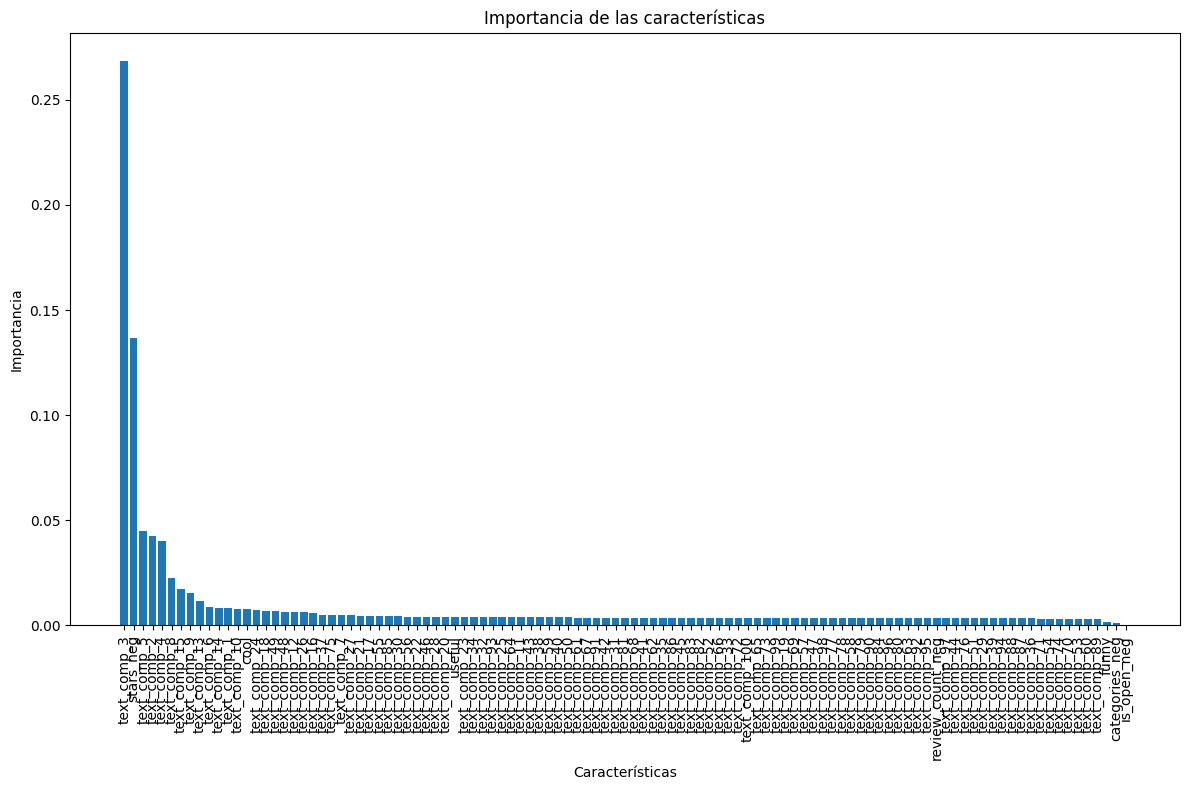

In [26]:
importances = model.feature_importances_

numeric_feature_names = list(X_numeric.columns)
text_feature_names = [f"text_comp_{i+1}" for i in range(X_text_reduced.shape[1])]
feature_names = numeric_feature_names + text_feature_names

indices = np.argsort(importances)[::-1]

# Crear la gráfica
plt.figure(figsize=(12, 8))
plt.title("Importancia de las características")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.tight_layout()
plt.show()

In [9]:
# Ahora, procesar el conjunto de test (sin ajustar de nuevo el vectorizador ni el SVD)
df_test = pd.read_csv('../data/test_reviews_merged_neg.csv')
df_test['text'] = df_test['text'].fillna("")

Y_numeric = df_test[["useful", "funny", "cool", "stars_neg", "review_count_neg", "categories_neg"]].copy()
Y_numeric["is_open_neg"] = df_test["is_open_neg"].astype(int)

Y_numeric

,useful,funny,cool,stars_neg,review_count_neg,categories_neg,is_open_neg
0,-0.063127,-0.164229,0.253789,4.5,1.375296,Restaurante,1
1,0.917552,-0.164229,0.759641,4.0,0.583200,Restaurante,1
2,0.263766,-0.164229,-0.252063,3.5,0.765382,Otros,1
3,0.263766,-0.164229,-0.252063,4.0,1.256481,Restaurante,1
4,-0.390020,-0.164229,-0.252063,2.5,3.561480,Hotelería,1
...,...,...,...,...,...,...,...
414760,-0.390020,-0.164229,-0.252063,4.0,15.997386,Restaurante,1
414761,-0.390020,-0.164229,-0.252063,4.0,-0.288106,Restaurante,1
414762,-0.390020,-0.164229,-0.252063,3.5,2.777305,Restaurante,0
414763,0.917552,-0.164229,0.253789,4.5,1.304007,Restaurante,0


In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y_numeric['categories_neg'] = label_encoder.fit_transform(Y_numeric['categories_neg'])

Y_numeric.sample(5)

,useful,funny,cool,stars_neg,review_count_neg,categories_neg,is_open_neg
244415,-0.063127,-0.164229,0.253789,4.0,5.937768,4,1
346947,-0.063127,-0.164229,0.253789,3.5,-0.042556,4,0
242858,-0.390020,-0.164229,-0.252063,4.5,13.755754,4,0
314009,-0.063127,-0.164229,-0.252063,4.0,7.957612,4,1
119624,-0.063127,-0.164229,-0.252063,4.0,4.662494,0,1


In [14]:
corpus_test = list(df_test['text'])
embeddings_test = model.encode(corpus_test, show_progress_bar=True)

np.save('embeddings_test_DL.npy', embeddings_test)

KeyboardInterrupt: 

In [ ]:
X_test = np.hstack([Y_numeric, Y_text_test_svd])

predictions = model.predict(X_test)

In [ ]:
# Crear el DataFrame con el formato requerido: review_id, stars
df_output = pd.DataFrame({
    'review_id': df_test['review_id'],
    'stars': predictions.round(0)
})

# Exportar el CSV con las predicciones
df_output.to_csv('random_forest_review_predictions_neg_1.csv', index=False)
print("Predicciones exportadas a 'random_forest_review_predictions_neg_1.csv'")

Predicciones exportadas a 'random_forest_review_predictions_neg_1.csv'
